In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_context('paper', font_scale=2)    


In [375]:
def get_talon_nov_colors(samples=None, how='normal'):
    c_dict = {'Known': '#009E73',
              'ISM': '#0072B2',
              'NIC': '#D55E00',
              'NNC': '#E69F00',
              'Antisense': '#000000',
              'Intergenic': '#CC79A7',
              'Genomic': '#F0E442'}
    if how == 'light_40':
        c_dict =  {'Known': '#66c5ab',
         'ISM':'#66aad1',
         'NIC': '#e69e66',
         'NNC': '#f0c566',
         'Antisense': '#666666',
         'Intergenic': '#e0afca',
         'Genomic': '#f6ef8e'}
    elif how == 'light_20':
        c_dict =  {'Known': '#33b18f',
         'ISM':'#338ec1',
         'NIC': '#dd7e33',
         'NNC': '#ebb233',
         'Antisense': '#333333',
         'Intergenic': '#d694b9',
         'Genomic': '#f3e968'}
        
    order = ['Known', 'ISM', 'NIC', 'NNC', 'Antisense', 'Intergenic', 'Genomic']
    if samples:
        keys = c_dict.keys()
        pop_list = []
        for key in keys:
            if key not in samples:
                pop_list.append(key)
        for p in pop_list:
            del c_dict[p]
        order = [o for o in order if o in samples]   
    return c_dict, order

In [373]:
def compute_prop_support(sj_file, ab_file, opref):
    sj_df = pd.read_csv(sj_file, sep='\t')
    ab = pd.read_csv(ab_file, sep='\t')  
    
    # merge with ab to get novelty info
    ab = ab[['annot_transcript_id', 'transcript_novelty']]
    sj_df = sj_df.merge(ab, how='left', left_on='tid', right_on='annot_transcript_id')    
    
    # count up splice junctions per transcript
    sjs_per_t = sj_df[['tid', 'sj_id']].groupby('tid').count()
    sjs_per_t.reset_index(inplace=True)
    sjs_per_t.rename({'sj_id':'total_sjs'}, axis=1, inplace=True)
    
    # groupby transcript id and illumina support
    sj_df = sj_df[['tid', 'transcript_novelty', 'illumina_support', 'sj_id']].groupby(['tid', 'transcript_novelty', 'illumina_support']).count()
    sj_df.reset_index(inplace=True)
    sj_df.rename({'sj_id':'n_sjs'}, axis=1, inplace=True)
    
    # merge with total sjs and calc % supported
    sj_df = sj_df.merge(sjs_per_t, how='left', on='tid')
    sj_df['perc_supported'] = (sj_df.n_sjs/sj_df.total_sjs)*100
    
    # remove unsupported bois
    sj_df = sj_df.loc[sj_df.illumina_support == True]

    # drop antisense, intergenic, and genomic cause they bad
    novs = ['Known', 'ISM', 'NIC', 'NNC']
    sj_df = sj_df.loc[sj_df.transcript_novelty.isin(novs)]
    
    # plot plot
    plt.figure(figsize=(8.5,8.5))
#     sns.set(font_scale=1.50)

	# font sizes
    plt.rc('font', size=14)

    c_dict, order = get_talon_nov_colors(novs)
    ax = sns.violinplot(data=sj_df, x='transcript_novelty', y='perc_supported', order=order, palette=c_dict, saturation=1, linewidth=0.5)
    ax.set_ylabel('% SJs in transcript supported by Illumina')
    ax.set_xlabel('Isoform Novelty')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fname = '{}_illumina_sj_support.pdf'.format(opref)
    plt.savefig(fname)
    
    # average and median of each category
    for n in novs: 
        temp = sj_df.loc[sj_df.transcript_novelty==n]
        print()
        print('Mean % Illumina supported SJs for {}: {}'.format(n, temp.perc_supported.mean()))
        print('Median % Illumina supported SJs for {}: {}'.format(n, temp.perc_supported.median()))    

In [8]:
def plot_unsupp_sjs_by_nov(sj_file, sj_nov_file, oprefix):
    sj_df = pd.read_csv(sj_file, sep='\t')
    nov_df = pd.read_csv(sj_nov_file, sep='\t', header=None, 
        usecols=[0,1,2,3,9], names=['chrom', 'start', 'stop', 'strand', 'novelty'])
    
    nov_df['sj_id'] = nov_df.chrom+'_'+nov_df.start.astype(str)+'_'+nov_df.stop.astype(str)+'_'+nov_df.strand.astype(str)
    nov_df = nov_df[['sj_id', 'novelty']]
    
    # limit to just sjs with no illumina support
    sj_df = sj_df.loc[sj_df.illumina_support == False]

    # merge with novelty of splice junctions
    sj_df = sj_df.merge(nov_df, how='left', on='sj_id')
    
    sj_df = sj_df[['sj_id', 'novelty']]
    sj_df.drop_duplicates(inplace=True)

    # groupby and count # of Illumina-supported SJs per SJ novelty category
    sj_df = sj_df.groupby('novelty').count()
    sj_df.reset_index(inplace=True)
    sj_df.rename({'sj_id':'sj_count'}, axis=1, inplace=True)
    
    # plot plot
    plt.figure(figsize=(8.5,8.5))
    plt.rc('font', size=14)

#     sns.set(font_scale=1.50)
    c_dict, order = get_talon_nov_colors(['Known', 'NIC', 'NNC'])
    ax = sns.barplot(data=sj_df, x='novelty', y='sj_count', palette=c_dict, hue_order=order, saturation=1)
    ax.set_ylabel('Number of SJs unsupported by Illumina')
    ax.set_xlabel('SJ Novelty')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    add_n(ax, sj_df, 'sj_count')
    
    fname = '{}_ill_unsupported_sj_novelty.pdf'.format(oprefix)
    plt.savefig(fname)

## PacBio

In [26]:
def add_n(ax, data, feature):
    total = data[feature].sum()
    ylim = ax.get_ylim()[1]
    for p in ax.patches:
        percentage = '{:,.0f}'.format(p.get_height())
        x_scale = 0.03*len(percentage)
        x = p.get_x() + p.get_width() / 2 - x_scale
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(percentage, (x, y), size = 15)


Mean % Illumina supported SJs for Known: 96.49993710385937
Median % Illumina supported SJs for Known: 100.0

Mean % Illumina supported SJs for ISM: 99.5236694953262
Median % Illumina supported SJs for ISM: 100.0

Mean % Illumina supported SJs for NIC: 98.11438401683239
Median % Illumina supported SJs for NIC: 100.0

Mean % Illumina supported SJs for NNC: 93.48281695577082
Median % Illumina supported SJs for NNC: 100.0


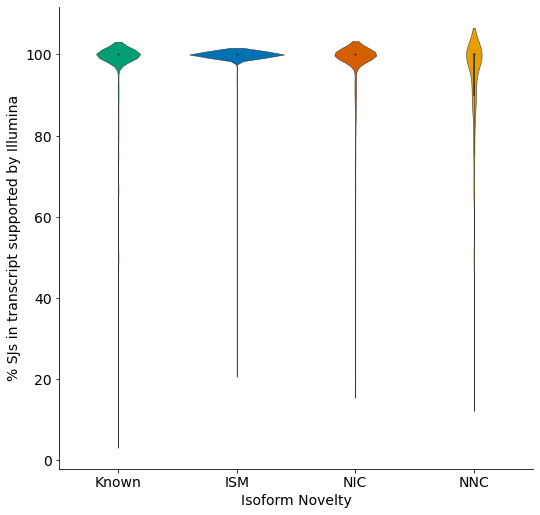

In [27]:
sj_file = 'pb_GM12878_sj_tid_support.tsv'
ab_file = 'pb_ont_talon_abundance_filtered.tsv'

compute_prop_support(sj_file, ab_file, 'figures/PB_GM12878')

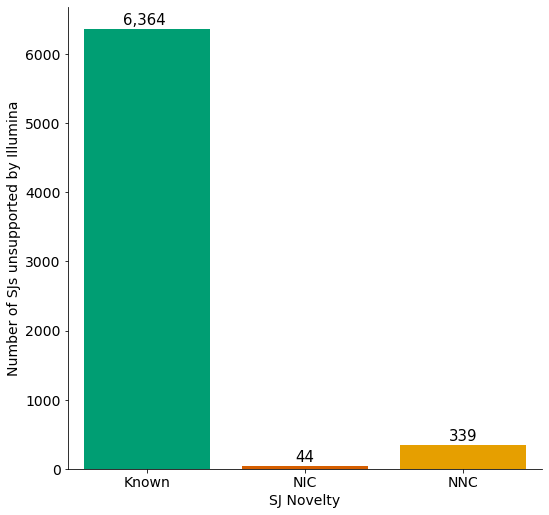

In [28]:
sj_file = 'pb_GM12878_sj_tid_support.tsv'
sj_nov_file = 'pb_talon_GM12878_sjs_novelty.tab'

plot_unsupp_sjs_by_nov(sj_file, sj_nov_file, 'figures/PB_GM12878')

## ONT


Mean % Illumina supported SJs for Known: 94.39099416715977
Median % Illumina supported SJs for Known: 100.0

Mean % Illumina supported SJs for ISM: 96.67296784336611
Median % Illumina supported SJs for ISM: 100.0

Mean % Illumina supported SJs for NIC: 82.87438998469071
Median % Illumina supported SJs for NIC: 85.71428571428571

Mean % Illumina supported SJs for NNC: 81.26478960319763
Median % Illumina supported SJs for NNC: 83.33333333333334


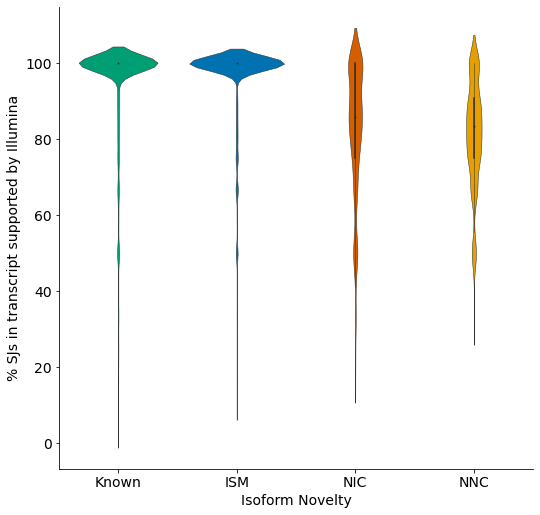

In [29]:
sj_file = 'ont_GM12878_sj_tid_support.tsv'
ab_file = 'pb_ont_talon_abundance_filtered.tsv'

compute_prop_support(sj_file, ab_file, 'figures/ONT_GM12878')

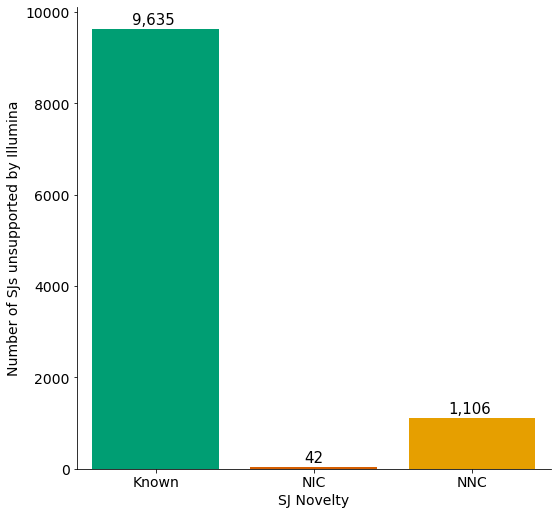

In [30]:
sj_file = 'ont_GM12878_sj_tid_support.tsv'
sj_nov_file = 'ont_talon_GM12878_sjs_novelty.tab'

plot_unsupp_sjs_by_nov(sj_file, sj_nov_file, 'figures/ONT_GM12878')

29236


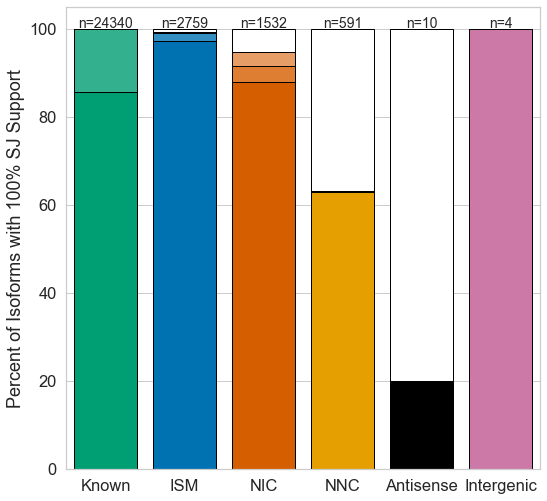

In [378]:
sj_support = 'pb_GM12878_sj_tid_support.tsv'
ab = 'pb_ont_talon_abundance_filtered.tsv'
sj_nov = 'pb_talon_GM12878_sjs_novelty.tab'

nov = comput_suport(sj_support, ab, sj_nov)
plot_plot(nov, 'pb_GM12878')

28241


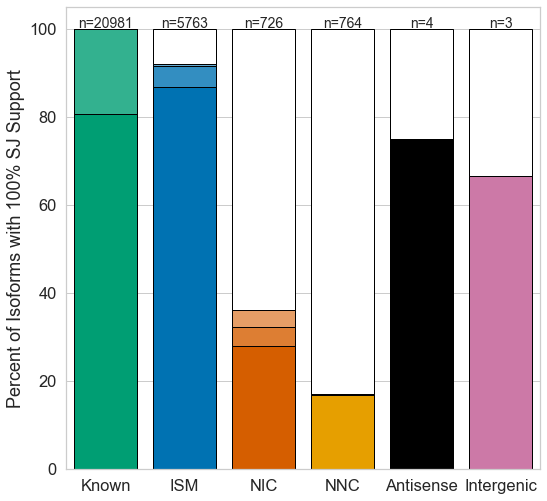

In [379]:
sj_support = 'ont_GM12878_sj_tid_support.tsv'
ab = 'pb_ont_talon_abundance_filtered.tsv'
sj_nov = 'ont_talon_GM12878_sjs_novelty.tab'

nov = comput_suport(sj_support, ab, sj_nov)
plot_plot(nov, 'ont_GM12878')

In [359]:
def comput_suport(sj_support, ab, sj_nov):
    df = pd.read_csv(sj_support, sep='\t')
    ab = pd.read_csv(ab, sep='\t')
    ab = ab[['annot_transcript_id', 'transcript_novelty']]
    df = df.merge(ab, how='left', left_on='tid', right_on='annot_transcript_id')

    support_df = df.loc[~df.tid.duplicated()]
    print(len(support_df.index))
    support_df = support_df[['tid', 'transcript_novelty']].groupby('transcript_novelty').count()
    support_df.reset_index(inplace=True)
    support_df.rename({'tid':'n_tids'}, axis=1, inplace=True)

    # merge with information about sj support
    nov_df = pd.read_csv(sj_nov, sep='\t', header=None, 
            usecols=[0,1,2,3,9], names=['chrom', 'start', 'stop', 'strand', 'sj_novelty'])
    nov_df['sj_id'] = nov_df.chrom+'_'+nov_df.start.astype(str)+'_'+nov_df.stop.astype(str)+'_'+nov_df.strand.astype(str)
    nov_df = nov_df[['sj_id', 'sj_novelty']]

    # merge with novelty of splice junctions
    df = df.merge(nov_df, how='left', on='sj_id')

    # count sjs per transcript
    sjs_per_t = df[['tid', 'transcript_novelty', 'sj_id']].groupby(['tid', 'transcript_novelty']).count()
    sjs_per_t.reset_index(inplace=True)
    sjs_per_t.rename({'sj_id':'total_sjs'}, axis=1, inplace=True)

    # what novelty are the remaining ones wrt gencode splice junctions? 
    temp = df[['tid', 'transcript_novelty', 'illumina_support', 'sj_id']].groupby(['tid', 'transcript_novelty', 'illumina_support']).count()
    temp.reset_index(inplace=True)
    temp.rename({'sj_id':'n_sjs_illumina'}, axis=1, inplace=True)
    temp = temp.loc[temp.illumina_support == True]

    # merge in with sjs per t
    sjs_per_t = sjs_per_t.merge(temp[['tid', 'n_sjs_illumina']], how='left', on='tid')

    # count the number of sjs per transcript that are supported by illumina or gencode
    df['ill_or_known'] = (df.illumina_support==True)|(df.sj_novelty=='Known')
    temp = df[['tid', 'ill_or_known', 'sj_id']].groupby(['tid', 'ill_or_known']).count()
    temp.reset_index(inplace=True)
    temp.rename({'sj_id':'n_sjs_ill_known'}, axis=1, inplace=True)
    temp = temp.loc[temp.ill_or_known == True]

    # merge in with sjs per t
    sjs_per_t = sjs_per_t.merge(temp[['tid', 'n_sjs_ill_known']], how='left', on='tid')

    # count the number of sjs/sss per transcript that are supported by illumina or gencode
    df['ill_known_nic'] = (df.illumina_support==True)|(df.sj_novelty.isin(['NIC', 'Known']))
    temp = df[['tid', 'ill_known_nic', 'sj_id']].groupby(['tid', 'ill_known_nic']).count()
    temp.reset_index(inplace=True)
    temp.rename({'sj_id':'n_sjs_ill_known_nic'}, axis=1, inplace=True)
    temp = temp.loc[temp.ill_known_nic == True]

    # merge in with sjs per t
    sjs_per_t = sjs_per_t.merge(temp[['tid', 'n_sjs_ill_known_nic']], how='left', on='tid')

    # fill nans with 0
    sjs_per_t.fillna(0, inplace=True)

    sjs_per_t['total_percent'] = 100
    # sjs_per_t['ill_percent'] = (sjs_per_t.n_sjs_illumina/sjs_per_t.total_sjs)*100
    # sjs_per_t['ill_known_percent'] = (sjs_per_t.n_sjs_ill_known/sjs_per_t.total_sjs)*100
    # sjs_per_t['ill_known_nic_percent'] = (sjs_per_t.n_sjs_ill_known_nic/sjs_per_t.total_sjs)*100

    sjs_per_t['full_ill_support'] = sjs_per_t.total_sjs == sjs_per_t.n_sjs_illumina
    sjs_per_t['full_ill_known_support'] = sjs_per_t.total_sjs == sjs_per_t.n_sjs_ill_known
    sjs_per_t['full_ill_known_nic_support'] = sjs_per_t.total_sjs == sjs_per_t.n_sjs_ill_known_nic
    sjs_per_t.head()

    nov = sjs_per_t[['tid', 'transcript_novelty']].groupby('transcript_novelty').count()
    nov.reset_index(inplace=True)
    nov.rename({'tid': 'n_transcripts'},axis=1, inplace=True)

    temp = sjs_per_t[['tid', 'transcript_novelty', 'full_ill_support']].groupby(['transcript_novelty', 'full_ill_support']).count()
    temp.reset_index(inplace=True)
    temp = temp.loc[temp.full_ill_support == True]
    temp.rename({'tid': 'ill_support'}, axis=1, inplace=True)
    temp = temp[['transcript_novelty', 'ill_support']]

    nov = nov.merge(temp, how='left', on='transcript_novelty')

    temp = sjs_per_t[['tid', 'transcript_novelty', 'full_ill_known_support']].groupby(['transcript_novelty', 'full_ill_known_support']).count()
    temp.reset_index(inplace=True)
    temp = temp.loc[temp.full_ill_known_support == True]
    temp.rename({'tid': 'ill_known_support'}, axis=1, inplace=True)
    temp = temp[['transcript_novelty', 'ill_known_support']]

    nov = nov.merge(temp, how='left', on='transcript_novelty')

    temp = sjs_per_t[['tid', 'transcript_novelty', 'full_ill_known_nic_support']].groupby(['transcript_novelty', 'full_ill_known_nic_support']).count()
    temp.reset_index(inplace=True)
    temp = temp.loc[temp.full_ill_known_nic_support == True]
    temp.rename({'tid': 'ill_known_nic_support'}, axis=1, inplace=True)
    temp = temp[['transcript_novelty', 'ill_known_nic_support']]

    nov = nov.merge(temp, how='left', on='transcript_novelty')

    cols = ['ill', 'ill_known', 'ill_known_nic']
    for c in cols: 
        nov['{}_perc'.format(c)] = (nov['{}_support'.format(c)]/nov['n_transcripts'])*100
    nov['total_percent'] =100
    return nov

In [250]:
df = pd.read_csv('pb_GM12878_sj_tid_support.tsv', sep='\t')
ab = pd.read_csv('pb_ont_talon_abundance_filtered.tsv', sep='\t')
ab = ab[['annot_transcript_id', 'transcript_novelty']]
df = df.merge(ab, how='left', left_on='tid', right_on='annot_transcript_id')

In [251]:
support_df = df.loc[~df.tid.duplicated()]
print(len(support_df.index))
support_df = support_df[['tid', 'transcript_novelty']].groupby('transcript_novelty').count()
support_df.reset_index(inplace=True)
support_df.rename({'tid':'n_tids'}, axis=1, inplace=True)

29236


In [252]:
# merge with information about sj support
nov_df = pd.read_csv('pb_talon_GM12878_sjs_novelty.tab', sep='\t', header=None, 
        usecols=[0,1,2,3,9], names=['chrom', 'start', 'stop', 'strand', 'sj_novelty'])
nov_df['sj_id'] = nov_df.chrom+'_'+nov_df.start.astype(str)+'_'+nov_df.stop.astype(str)+'_'+nov_df.strand.astype(str)
nov_df = nov_df[['sj_id', 'sj_novelty']]

# merge with novelty of splice junctions
df = df.merge(nov_df, how='left', on='sj_id')

In [253]:
# count sjs per transcript
sjs_per_t = df[['tid', 'transcript_novelty', 'sj_id']].groupby(['tid', 'transcript_novelty']).count()
sjs_per_t.reset_index(inplace=True)
sjs_per_t.rename({'sj_id':'total_sjs'}, axis=1, inplace=True)

In [254]:
print(len(sjs_per_t.index))

29236


In [255]:
# what novelty are the remaining ones wrt gencode splice junctions? 
temp = df[['tid', 'transcript_novelty', 'illumina_support', 'sj_id']].groupby(['tid', 'transcript_novelty', 'illumina_support']).count()
temp.reset_index(inplace=True)
temp.rename({'sj_id':'n_sjs_illumina'}, axis=1, inplace=True)
temp = temp.loc[temp.illumina_support == True]

In [256]:
# merge in with sjs per t
sjs_per_t = sjs_per_t.merge(temp[['tid', 'n_sjs_illumina']], how='left', on='tid')

In [257]:
sjs_per_t.head()

,tid,transcript_novelty,total_sjs,n_sjs_illumina
0,ENCODEHT000207494,NIC,20,20.0
1,ENCODEHT000207610,NIC,10,10.0
2,ENCODEHT000207695,ISM,5,5.0
3,ENCODEHT000207709,ISM,2,2.0
4,ENCODEHT000207748,ISM,6,6.0


In [258]:
# count the number of sjs per transcript that are supported by illumina or gencode
df['ill_or_known'] = (df.illumina_support==True)|(df.sj_novelty=='Known')
temp = df[['tid', 'ill_or_known', 'sj_id']].groupby(['tid', 'ill_or_known']).count()
temp.reset_index(inplace=True)
temp.rename({'sj_id':'n_sjs_ill_known'}, axis=1, inplace=True)
temp = temp.loc[temp.ill_or_known == True]

In [259]:
# merge in with sjs per t
sjs_per_t = sjs_per_t.merge(temp[['tid', 'n_sjs_ill_known']], how='left', on='tid')

In [260]:
# count the number of sjs/sss per transcript that are supported by illumina or gencode
df['ill_known_nic'] = (df.illumina_support==True)|(df.sj_novelty.isin(['NIC', 'Known']))
temp = df[['tid', 'ill_known_nic', 'sj_id']].groupby(['tid', 'ill_known_nic']).count()
temp.reset_index(inplace=True)
temp.rename({'sj_id':'n_sjs_ill_known_nic'}, axis=1, inplace=True)
temp = temp.loc[temp.ill_known_nic == True]

In [261]:
# merge in with sjs per t
sjs_per_t = sjs_per_t.merge(temp[['tid', 'n_sjs_ill_known_nic']], how='left', on='tid')

In [269]:
# fill nans with 0
sjs_per_t.fillna(0, inplace=True)

In [282]:
sjs_per_t['total_percent'] = 100
# sjs_per_t['ill_percent'] = (sjs_per_t.n_sjs_illumina/sjs_per_t.total_sjs)*100
# sjs_per_t['ill_known_percent'] = (sjs_per_t.n_sjs_ill_known/sjs_per_t.total_sjs)*100
# sjs_per_t['ill_known_nic_percent'] = (sjs_per_t.n_sjs_ill_known_nic/sjs_per_t.total_sjs)*100

sjs_per_t['full_ill_support'] = sjs_per_t.total_sjs == sjs_per_t.n_sjs_illumina
sjs_per_t['full_ill_known_support'] = sjs_per_t.total_sjs == sjs_per_t.n_sjs_ill_known
sjs_per_t['full_ill_known_nic_support'] = sjs_per_t.total_sjs == sjs_per_t.n_sjs_ill_known_nic
sjs_per_t.head()

,tid,transcript_novelty,total_sjs,n_sjs_illumina,n_sjs_ill_known,n_sjs_ill_known_nic,total_percent,ill_percent,ill_known_percent,ill_known_nic_percent,full_ill_support,full_ill_known_support,full_ill_known_nic_support
0,ENCODEHT000207494,NIC,20,20.0,20.0,20.0,100,100.0,100.0,100.0,True,True,True
1,ENCODEHT000207610,NIC,10,10.0,10.0,10.0,100,100.0,100.0,100.0,True,True,True
2,ENCODEHT000207695,ISM,5,5.0,5.0,5.0,100,100.0,100.0,100.0,True,True,True
3,ENCODEHT000207709,ISM,2,2.0,2.0,2.0,100,100.0,100.0,100.0,True,True,True
4,ENCODEHT000207748,ISM,6,6.0,6.0,6.0,100,100.0,100.0,100.0,True,True,True


In [317]:
nov = sjs_per_t[['tid', 'transcript_novelty']].groupby('transcript_novelty').count()
nov.reset_index(inplace=True)
nov.rename({'tid': 'n_transcripts'},axis=1, inplace=True)

In [318]:
nov.head()

,transcript_novelty,n_transcripts
0,Antisense,10
1,ISM,2759
2,Intergenic,4
3,Known,24340
4,NIC,1532


In [319]:
temp = sjs_per_t[['tid', 'transcript_novelty', 'full_ill_support']].groupby(['transcript_novelty', 'full_ill_support']).count()
temp.reset_index(inplace=True)
temp = temp.loc[temp.full_ill_support == True]
temp.rename({'tid': 'ill_support'}, axis=1, inplace=True)
temp = temp[['transcript_novelty', 'ill_support']]

nov = nov.merge(temp, how='left', on='transcript_novelty')

In [320]:
temp = sjs_per_t[['tid', 'transcript_novelty', 'full_ill_known_support']].groupby(['transcript_novelty', 'full_ill_known_support']).count()
temp.reset_index(inplace=True)
temp = temp.loc[temp.full_ill_known_support == True]
temp.rename({'tid': 'ill_known_support'}, axis=1, inplace=True)
temp = temp[['transcript_novelty', 'ill_known_support']]

nov = nov.merge(temp, how='left', on='transcript_novelty')

In [321]:
temp = sjs_per_t[['tid', 'transcript_novelty', 'full_ill_known_nic_support']].groupby(['transcript_novelty', 'full_ill_known_nic_support']).count()
temp.reset_index(inplace=True)
temp = temp.loc[temp.full_ill_known_nic_support == True]
temp.rename({'tid': 'ill_known_nic_support'}, axis=1, inplace=True)
temp = temp[['transcript_novelty', 'ill_known_nic_support']]

nov = nov.merge(temp, how='left', on='transcript_novelty')

In [322]:
nov

,transcript_novelty,n_transcripts,ill_support,ill_known_support,ill_known_nic_support
0,Antisense,10,2,2,2
1,ISM,2759,2686,2737,2740
2,Intergenic,4,4,4,4
3,Known,24340,20880,24340,24340
4,NIC,1532,1349,1403,1451
5,NNC,591,372,373,373


In [324]:
cols = ['ill', 'ill_known', 'ill_known_nic']
for c in cols: 
    nov['{}_perc'.format(c)] = (nov['{}_support'.format(c)]/nov['n_transcripts'])*100

In [326]:
nov['total_percent'] =100
nov

,transcript_novelty,n_transcripts,ill_support,ill_known_support,ill_known_nic_support,ill_perc,ill_known_perc,ill_known_nic_perc,total_percent
0,Antisense,10,2,2,2,20.000000,20.000000,20.000000,100
1,ISM,2759,2686,2737,2740,97.354114,99.202610,99.311345,100
2,Intergenic,4,4,4,4,100.000000,100.000000,100.000000,100
3,Known,24340,20880,24340,24340,85.784717,100.000000,100.000000,100
4,NIC,1532,1349,1403,1451,88.054830,91.579634,94.712794,100
5,NNC,591,372,373,373,62.944162,63.113367,63.113367,100


In [377]:
def plot_plot(nov, opref):
    
    c_dict, order = get_talon_nov_colors(['Known', 'ISM', 'NIC', 'NNC', 'Intergenic', 'Antisense'])
    c_dict_40, order = get_talon_nov_colors(['Known', 'ISM', 'NIC', 'NNC', 'Intergenic', 'Antisense'], how='light_40')
    c_dict_20, order = get_talon_nov_colors(['Known', 'ISM', 'NIC', 'NNC', 'Intergenic', 'Antisense'], how='light_20')

    
    # plotting
    plt.figure(figsize=(8.5,8.5))
    sns.set(font_scale=1.5, style="whitegrid")

    # font sizes
    plt.rc('font', size=14)

    top_plot = sns.barplot(x='transcript_novelty', y='total_percent', data=nov, 
        color='white', order=order, edgecolor='black')
    p2 = sns.barplot(x='transcript_novelty', y='ill_known_nic_perc', 
        data=nov, palette=c_dict_40, order=order,
        edgecolor='black', saturation=1)
    p2 = sns.barplot(x='transcript_novelty', y='ill_known_perc', 
        data=nov, palette=c_dict_20, saturation=1, order=order,
        edgecolor='black')
    bottom_plot = sns.barplot(x='transcript_novelty', y='ill_perc', 
        data=nov, palette=c_dict, saturation=1, order=order,
        edgecolor='black')

    topbar = plt.Rectangle((0,0),1,1,fc='white', edgecolor='black')
    bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor='black')

    # plt.title('{} SJ Support by Isoform Novelty'.format(args.sample_name))
    plt.xlabel('')
    bottom_plot.set_ylabel("Percent of Isoforms with 100% SJ Support")
    for ntype, p in zip(order, bottom_plot.patches):
        height = p.get_height()
        bottom_plot.text(p.get_x()+p.get_width()/2.,
                height + .3,
                'n={}'.format(nov.loc[nov['transcript_novelty']==ntype]['n_transcripts'].values[0]),
                ha="center")
    # bottom_plot.set_xticklabels(bottom_plot.get_xticklabels(), fontsize=14)    # fontsize of the x and y labels
    fname = '{}_sj_support_isoform.pdf'.format(opref)
    plt.savefig(fname)

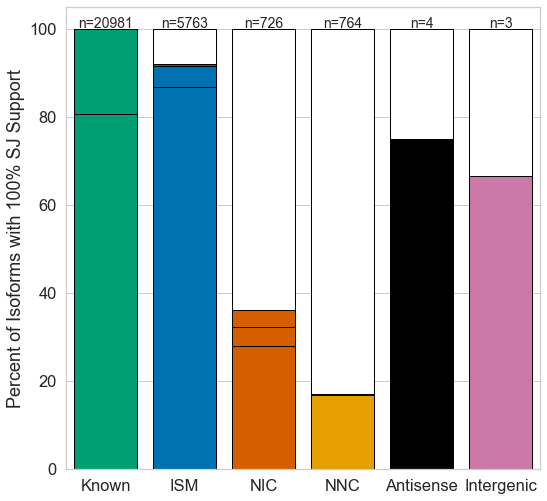

In [371]:
plot_plot(nov, 'PB_GM12878')

In [270]:
temp.loc[temp.tid == 'ENCODEHT000217262']

,tid,ill_known_nic,n_sjs_ill_known_nic


In [271]:
df.loc[df.tid == 'ENCODEHT000209674']

,tid,sj_id,illumina_support,gencode_support,annot_transcript_id,transcript_novelty,sj_novelty,ill_or_known,ill_known_nic
130889,ENCODEHT000209674,chr13_27424939_27427093_1,False,False,ENCODEHT000209674,NNC,NNC,False,False
130890,ENCODEHT000209674,chr13_27427193_27429869_1,True,True,ENCODEHT000209674,NNC,Known,True,True
130891,ENCODEHT000209674,chr13_27429967_27430532_1,True,True,ENCODEHT000209674,NNC,Known,True,True
130892,ENCODEHT000209674,chr13_27430622_27432730_1,True,True,ENCODEHT000209674,NNC,Known,True,True
130893,ENCODEHT000209674,chr13_27432805_27434138_1,True,True,ENCODEHT000209674,NNC,Known,True,True
130894,ENCODEHT000209674,chr13_27434220_27434804_1,True,True,ENCODEHT000209674,NNC,Known,True,True
130895,ENCODEHT000209674,chr13_27435035_27435132_1,True,True,ENCODEHT000209674,NNC,Known,True,True
130896,ENCODEHT000209674,chr13_27435193_27435432_1,True,True,ENCODEHT000209674,NNC,Known,True,True


In [272]:
sjs_per_t.head()

,tid,transcript_novelty,total_sjs,n_sjs_illumina,n_sjs_ill_known,n_sjs_ill_known_nic
0,ENCODEHT000207494,NIC,20,20.0,20.0,20.0
1,ENCODEHT000207610,NIC,10,10.0,10.0,10.0
2,ENCODEHT000207695,ISM,5,5.0,5.0,5.0
3,ENCODEHT000207709,ISM,2,2.0,2.0,2.0
4,ENCODEHT000207748,ISM,6,6.0,6.0,6.0


In [273]:
# wtf is ISM doing here
sjs_per_t.loc[sjs_per_t.n_sjs_ill_known != sjs_per_t.n_sjs_ill_known_nic].transcript_novelty.unique()

array(['NIC', 'ISM'], dtype=object)

In [274]:
sjs_per_t.loc[sjs_per_t.tid == 'ENCODEHT000274449']

,tid,transcript_novelty,total_sjs,n_sjs_illumina,n_sjs_ill_known,n_sjs_ill_known_nic
667,ENCODEHT000274449,ISM,1,0.0,0.0,0.0


In [275]:
df.loc[df.tid == 'ENCODEHT000274449']

,tid,sj_id,illumina_support,gencode_support,annot_transcript_id,transcript_novelty,sj_novelty,ill_or_known,ill_known_nic
197132,ENCODEHT000274449,chr5_55941820_55942669_1,False,False,ENCODEHT000274449,ISM,NNC,False,False


In [276]:
sjs_per_t.loc[(sjs_per_t.n_sjs_ill_known != sjs_per_t.n_sjs_ill_known_nic)&(sjs_per_t.transcript_novelty == 'ISM')]

,tid,transcript_novelty,total_sjs,n_sjs_illumina,n_sjs_ill_known,n_sjs_ill_known_nic
229,ENCODEHT000230837,ISM,2,1.0,1.0,2.0
1414,ENCODEHT000349514,ISM,9,8.0,8.0,9.0
3305,ENCODEHT000549185,ISM,7,6.0,6.0,7.0


In [247]:
df.loc[df.tid == 'ENCODEHT000230837']

,tid,sj_id,illumina_support,gencode_support,annot_transcript_id,transcript_novelty,sj_novelty,ill_or_known,ill_known_nic
57188,ENCODEHT000230837,chr5_1632907_1633807_2,True,True,ENCODEHT000230837,ISM,Known,True,True
57189,ENCODEHT000230837,chr5_1629631_1632844_2,False,False,ENCODEHT000230837,ISM,NIC,False,True


In [277]:
sjs_per_t.loc[sjs_per_t.n_sjs_illumina != sjs_per_t.n_sjs_ill_known]

,tid,transcript_novelty,total_sjs,n_sjs_illumina,n_sjs_ill_known,n_sjs_ill_known_nic
118,ENCODEHT000222269,NIC,11,9.0,11.0,11.0
126,ENCODEHT000223232,ISM,15,8.0,15.0,15.0
127,ENCODEHT000223235,ISM,14,7.0,14.0,14.0
149,ENCODEHT000225833,ISM,12,10.0,12.0,12.0
152,ENCODEHT000226184,ISM,1,0.0,1.0,1.0
...,...,...,...,...,...,...
29208,ENST00000649858.1,Known,11,10.0,11.0,11.0
29217,ENST00000650112.1,Known,2,1.0,2.0,2.0
29219,ENST00000650127.1,Known,20,4.0,20.0,20.0
29220,ENST00000650131.1,Known,3,2.0,3.0,3.0


In [278]:
sjs_per_t.loc[sjs_per_t.tid == 'ENCODEHT000274449']

,tid,transcript_novelty,total_sjs,n_sjs_illumina,n_sjs_ill_known,n_sjs_ill_known_nic
667,ENCODEHT000274449,ISM,1,0.0,0.0,0.0
